# Napari Python Application for Westmeyer Lab
Run the Imports and Napari Window to open Napari Viewer. 

# Imports and Napari Window

### Imports

In [1]:
import napari
from magicgui import magic_factory, widgets
from skimage import data
from skimage.util import img_as_float
from magicgui import magicgui
from pathlib import Path
import os
import shutil
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.measure import regionprops
from skimage import exposure, morphology, measure
import plotly.graph_objs as go
import pandas as pd
import seaborn as sns
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from scipy.ndimage import gaussian_filter1d
#from plotly.io import to_html
#viewer = napari.view_image(nuclei, colormap='magma')

### Functions and Napari Window

In [2]:
@magic_factory(input_directory={'label': 'Write directory to merge images'}) #(merge_images={"widget_type": "FloatSlider", "max": 1}, auto_call=True)
def merge(input_directory: str) -> None: #'napari.types.LabelsData'
    merge.native.setWindowTitle("Merge Images")
    image_paths = [os.path.join(input_directory, f) for f in os.listdir(input_directory) if f.endswith('.tif') or f.endswith('.tiff') or f.endswith('.TIF')]

    if not image_paths:
        print("No .tif files found in the directory.")
        return
    
    image_paths.sort()  # Sort the image paths in ascending order
    images = [Image.open(path) for path in image_paths]
    filename = os.path.join(input_directory, 'MergedImages.tif')
    images[0].save(filename, save_all=True, append_images=images[1:])
    print("Images merged successfully!")

@magic_factory(src_folder={'label': 'Paste the path to move images'})
def move(src_folder: str, No_of_Channels: int) -> None:
    # Create the parent directory for channels
    parent_folder = os.path.join(src_folder, 'Chnls')
    os.makedirs(parent_folder, exist_ok=True)
    
    # Create destination folders in the parent folder
    dest_folders = [os.path.join(parent_folder, f"Ch{i+1}") for i in range(No_of_Channels)]

    # Make sure each destination folder exists
    for folder in dest_folders:
        os.makedirs(folder, exist_ok=True)
    
    # Get a list of all files in the source folder and sort them alphabetically
    files = sorted(os.listdir(src_folder))
    
    # Move images to the destination folders
    for i, filename in enumerate(files):
        src_path = os.path.join(src_folder, filename)

        # Ensure we only move files, not directories, and skip hidden files
        if os.path.isfile(src_path) and not filename.startswith('.'):
            dest_folder = dest_folders[i % No_of_Channels]
            dest_path = os.path.join(dest_folder, filename)
            
            try:
                shutil.move(src_path, dest_path)
                print(f"Moved {filename} to {dest_path}")
            except Exception as e:
                print(f"Error moving {filename} to {dest_path}: {e}")
        else:
            print(f"Skipping {filename}, not a file or hidden.")

@magic_factory(layer={"label": "Select Layer to turn into numpy array"})
def get_layer_as_array(viewer: 'napari.Viewer', layer: 'napari.layers.Layer') -> np.ndarray:
    if layer is None:
        print("No layer selected.")
        return

    # Get the data from the selected layer
    data = layer.data
    
    # Convert the data to a numpy array
    deneme = np.array(data)
    
    # Add the image to the viewer (optional)
    viewer.add_image(deneme, name=f"Numpy array {layer.name}")

@magic_factory(
    image_layer={"label": "Select Image Layer"},
    histogram_equalization={"widget_type": "Checkbox", "text": "Hist. Eq. (CLAHE)"},
    clip_limit={"widget_type": "FloatSlider", "max": 40, "min": 1, "step": 0.5, "label": "CLAHE Clip Limit"},
    normalization={"widget_type": "Checkbox", "text": "Normalization"},
    resize_to_512_512={"widget_type": "Checkbox", "text": "Resize to 512x512"},
    denoising={"widget_type": "Checkbox", "text": "Denoising"},
    h_value={"widget_type": "Slider", "max": 100, "min": 0, "step": 1, "label": "Denoising Strength (h value)"}
)
def preprocess_image(
    viewer: 'napari.Viewer', 
    image_layer: 'napari.layers.Image', 
    histogram_equalization: bool = False, 
    clip_limit: float = 5.0,
    normalization: bool = False, 
    resize_to_512_512: bool = False, 
    denoising: bool = False, 
    h_value: int = 15
) -> np.ndarray:
    
    if image_layer is None:
        print("No image layer selected.")
        return

    img_stack = image_layer.data
    processed_stack = []

    preprocessing_selected = histogram_equalization or normalization or resize_to_512_512 or denoising

    if not preprocessing_selected:
        print("No preprocessing selected.")
        return

    for img in img_stack:
        processed_image = img.copy()  # Make a copy of the original image

        if histogram_equalization:
            clahe = cv2.createCLAHE(clipLimit=clip_limit)
            processed_image = clahe.apply(processed_image)

        if normalization:
            processed_image = (processed_image - np.min(processed_image)) / (np.max(processed_image) - np.min(processed_image))
        
        # Ensure the processed image is in float32 format for OpenCV operations
        #processed_image = (processed_image * 255).astype(np.float32)

        if resize_to_512_512:
            processed_image = cv2.resize(processed_image, (512, 512))

        if denoising:
            processed_image = processed_image.astype(np.uint8)
            processed_image = cv2.fastNlMeansDenoising(processed_image, None, h=h_value)

        # Ensure the final image is in uint8 format for display
        #processed_image = processed_image.astype(np.uint8)
        processed_stack.append(processed_image)

    processed_stack = np.array(processed_stack)


    # Add the processed image stack as a new layer in the napari viewer
    viewer.add_image(processed_stack, name="Processed Image")

@magic_factory(layer={"label": "Select Layer to take image from"})
def select_image(layer: napari.layers.Image,image_index: int) -> None:
    """Select and display a single image from the stack."""
    if layer is None:
        print("No layer selected.")
        return
    img_stack = layer.data
    if image_index < 0 or image_index >= img_stack.shape[0]:
        print("Index out of range.")
        return
    single_image = img_stack[image_index]
    viewer.add_image(single_image, name='Selected Single Image')

###########################

@magic_factory(image_stack={'label': 'Select Image Stack Layer'}, mask_layer={'label': 'Select Mask Layer'})
def plot_fluorescence(image_stack: 'napari.layers.Image', mask_layer: 'napari.layers.Labels') -> None:

    if image_stack is None or mask_layer is None:
        print("No image stack or mask layer selected.")
        return

    image_stack_data = image_stack.data
    mask_data = mask_layer.data

    cell_fluorescence = {}

    if len(image_stack_data.shape) == 4:
        for cell_id in np.unique(mask_data):
            if cell_id == 0:  # Skip background
                continue
            cell_mask = mask_data == cell_id
            cell_fluorescence[cell_id] = [
                frame[cell_mask].mean() for frame in image_stack_data[:, 0, :, :]
            ]
        
    elif len(image_stack_data.shape) == 3:
        for cell_id in np.unique(mask_data):
            if cell_id == 0:  # Skip background
                continue
            cell_mask = mask_data == cell_id
            cell_fluorescence[cell_id] = [
                frame[cell_mask].mean() for frame in image_stack_data
            ]
    
    data = []
    for cell_id, fluorescence in cell_fluorescence.items():
        for frame, intensity in enumerate(fluorescence):
            data.append([cell_id, frame, intensity])
    df = pd.DataFrame(data, columns=['Cell ID', 'Time (Frames)', 'Fluorescence Intensity'])

    stats = df.groupby('Cell ID')['Fluorescence Intensity'].agg(['max', 'mean'])
    stats['Combined Metric'] = stats['max'] * 0.7 + stats['mean'] * 0.3

    sorted_cell_ids = stats.sort_values('Combined Metric').index

    spacing = 0.01  # Fixed spacing value for linear separation
    offsets = {cell_id: i * spacing for i, cell_id in enumerate(sorted_cell_ids)}

    df['Offset Intensity'] = df.apply(
        lambda row: row['Fluorescence Intensity'] + offsets[row['Cell ID']],
        axis=1
    )

    ##########################
    ##### Plotting fluorescence data for each cell using Plotly

    fig = go.Figure()
    
    for cell_id, fluorescence in cell_fluorescence.items():
        fig.add_trace(go.Scatter(
            x=list(range(len(fluorescence))), 
            y=fluorescence, 
            mode='lines', 
            name=f'Cell {cell_id}'
        ))
    
    # Update layout
    fig.update_layout(
        title='Fluorescence Intensity of Cells Over Time',
        xaxis_title='Time (Frames)',
        yaxis_title='Fluorescence Intensity',
        xaxis=dict(zeroline=True),
        yaxis=dict(zeroline=True)
    )

    # Show plot
    fig.show()

    ##########################
    ##### Plotting fluorescence data for each cell using Seaborn
    
    # Plot
    #plt.ioff()  # Turn off interactive mode
    fig, ax = plt.subplots(figsize=(5, 8))
    fig.patch.set_facecolor('black')
    fig.patch.set_edgecolor('black')
    ax.set_facecolor('black')

    #ax = fig.add_subplot(111)
    #ax.set_position([0, 0, 1, 1])  # Fill the figure
    
    sigma = 2
    for cell_id in sorted_cell_ids:
        data = df[df['Cell ID'] == cell_id]
        x = data['Time (Frames)']
        y = data['Offset Intensity']
        y_smooth = gaussian_filter1d(y, sigma=sigma)
        ax.plot(x, y_smooth, color='white', linewidth=1.5)
        ax.text(x.iloc[0] - 10, y_smooth[0], f'Cell {cell_id}', fontsize=8, color='white', ha='right', va='center')

    ax.set_xlabel('Time (Frames)', color='white')  # X-axis label color
    ax.tick_params(axis='x', colors='white')  # X-axis ticks color
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.grid(False)
    plt.tight_layout()

    canvas = FigureCanvas(fig)
    viewer.window.add_dock_widget(canvas, name="Plot")
    
##########################

@magic_factory(cellid={'label': 'Select Cell ID Number'}, mask_layer={'label': 'Select Mask Layer'})
def highlight(cellid: int, mask_layer: 'napari.layers.Labels') -> "napari.types.LabelsData":
    roi = mask_layer.data == cellid
    viewer.add_labels(roi, name=f'Cell_{cellid}')

###########################

my_widget1 = merge()
my_widget2 = move()
my_widget3 = get_layer_as_array()
my_widget4 = preprocess_image()
my_widget5 = select_image()
my_widget6 = plot_fluorescence()
my_widget7 = highlight()
viewer = napari.Viewer()

dw3 = viewer.window.add_dock_widget(my_widget3, name="Turn Image to Numpy Array")
dw4 = viewer.window.add_dock_widget(my_widget4, name="Image Preprocessing")

dw5 = viewer.window.add_dock_widget(my_widget5, name="Select a Single Image From Stack")
dw6 = viewer.window.add_dock_widget(my_widget6, name="Plot the Fluorescence of Cells")
dw7 = viewer.window.add_dock_widget(my_widget7, name="Select a Spesific Cell From Mask")

viewer.window._qt_window.tabifyDockWidget(dw3, dw4)
viewer.window._qt_window.tabifyDockWidget(dw6, dw7)

/opt/homebrew/Caskroom/miniforge/base/envs/napari-env/lib/python3.12/site-packages/pytools/persistent_dict.py:59: UserWarning: pytools.persistent_dict: unable to import 'siphash24.siphash13', falling back to hashlib.sha256
  warn("pytools.persistent_dict: unable to import 'siphash24.siphash13', "


### Run this if you also want to organize CX07 File output

In [ ]:
dw1 = viewer.window.add_dock_widget(my_widget1, name="Merge Images to Single TIF")
dw2 = viewer.window.add_dock_widget(my_widget2, name="Move Images Into Folders")
viewer.window._qt_window.tabifyDockWidget(dw2, dw1)

# Template Code if Necessary

#### Print all layers in Viewer and load their data

In [ ]:
print(viewer.layers)

[<Image layer 'a' at 0x30ecfc0b0>, <Labels layer 'm_cp_masks_000' at 0x31fbf89e0>]


In [ ]:
img = viewer.layers[0]
imgdata = img.data
mask = viewer.layers[1]
maskdata = mask.data
print(np.shape(imgdata))
print(np.shape(maskdata))
#deneme= np.array(data)
#viewer.add_image(deneme)

(359, 1104, 1104)
(1104, 1104)


#### How to Create Fluorescence Plots

In [ ]:
image_stack = img
mask_layer = mask

# Get the data from the selected layers
image_stack_data = image_stack.data
mask_data = mask_layer.data

# Collect fluorescence data for each cell
cell_fluorescence = {}

# Process the image stack
if len(image_stack_data.shape) == 4:
    # 4D stack (n, c, h, w)
    for cell_id in np.unique(mask_data):
        if cell_id == 0:  # Skip background
            continue
        cell_mask = mask_data == cell_id
        cell_fluorescence[cell_id] = [
            frame[cell_mask].mean() for frame in image_stack_data[:, 0, :, :]
        ]
    
elif len(image_stack_data.shape) == 3:
    # 3D stack (c, h, w)
    for cell_id in np.unique(mask_data):
        if cell_id == 0:  # Skip background
            continue
        cell_mask = mask_data == cell_id
        cell_fluorescence[cell_id] = [
            frame[cell_mask].mean() for frame in image_stack_data
        ]
print('we are here')
# Plotting fluorescence data for each cell using Plotly
fig = go.Figure()

for cell_id, fluorescence in cell_fluorescence.items():
    fig.add_trace(go.Scatter(
        x=list(range(len(fluorescence))), 
        y=fluorescence, 
        mode='lines', 
        name=f'Cell {cell_id}'
    ))

# Update layout
fig.update_layout(
    title='Fluorescence Intensity of Cells Over Time',
    xaxis_title='Time (Frames)',
    yaxis_title='Fluorescence Intensity',
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True)
)

# Show plot
fig.show()



we are here


In [ ]:
# Sample data, replace with actual data
image_stack = img
mask_layer = mask

# Get the data from the selected layers
image_stack_data = image_stack.data
mask_data = mask_layer.data

# Collect fluorescence data for each cell
cell_fluorescence = {}
if len(image_stack_data.shape) == 4:
    for cell_id in np.unique(mask_data):
        if cell_id == 0:
            continue
        cell_mask = mask_data == cell_id
        cell_fluorescence[cell_id] = [
            frame[cell_mask].mean() for frame in image_stack_data[:, 0, :, :]
        ]
elif len(image_stack_data.shape) == 3:
    for cell_id in np.unique(mask_data):
        if cell_id == 0:
            continue
        cell_mask = mask_data == cell_id
        cell_fluorescence[cell_id] = [
            frame[cell_mask].mean() for frame in image_stack_data
        ]

# Convert cell_fluorescence to a DataFrame for seaborn plotting
data = []
for cell_id, fluorescence in cell_fluorescence.items():
    for frame, intensity in enumerate(fluorescence):
        data.append([cell_id, frame, intensity])
df = pd.DataFrame(data, columns=['Cell ID', 'Time (Frames)', 'Fluorescence Intensity'])

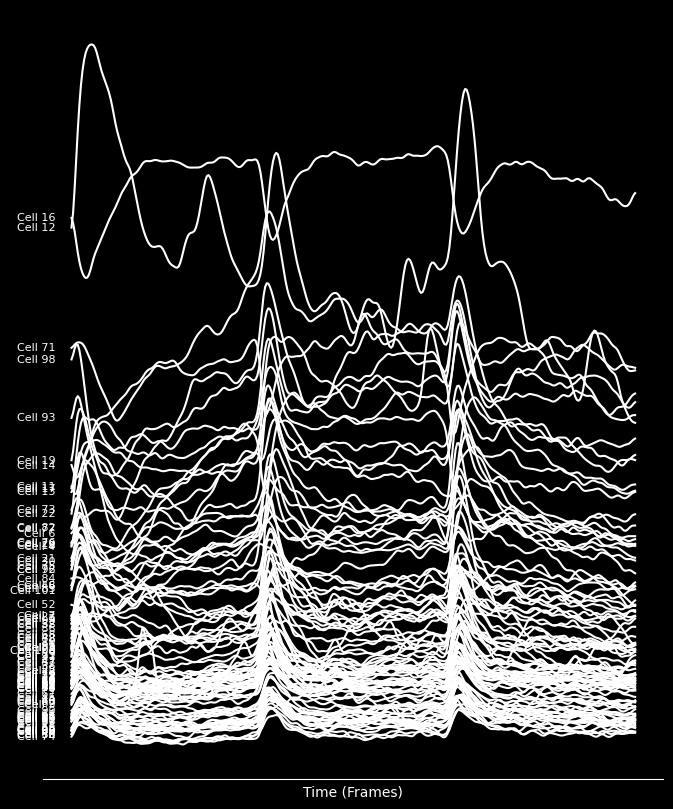

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Calculate max and mean for each Cell ID
stats = df.groupby('Cell ID')['Fluorescence Intensity'].agg(['max', 'mean'])
stats['Combined Metric'] = stats['max'] * 0.7 + stats['mean'] * 0.3

# Sort by Combined Metric
sorted_cell_ids = stats.sort_values('Combined Metric').index

# Define the spacing for linear separation
spacing = 0.01  # Fixed spacing value for linear separation

# Offset each line by adding a unique value for each sorted Cell ID
offsets = {cell_id: i * spacing for i, cell_id in enumerate(sorted_cell_ids)}

# Add the offset to each cell's fluorescence intensity
df['Offset Intensity'] = df.apply(
    lambda row: row['Fluorescence Intensity'] + offsets[row['Cell ID']],
    axis=1
)

# Initialize the plot
fig = plt.figure(figsize=(8, 10))
plt.style.use('dark_background')

# Smoothing with Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 2  # Adjust smoothing level

# Plot each line
for cell_id in sorted_cell_ids:
    data = df[df['Cell ID'] == cell_id]
    x = data['Time (Frames)']
    y = data['Offset Intensity']

    # Apply Gaussian smoothing
    y_smooth = gaussian_filter1d(y, sigma=sigma)
    
    plt.plot(x, y_smooth, color='white', linewidth=1.5)
    plt.text(x.iloc[0] - 10, y_smooth[0], f'Cell {cell_id}', fontsize=8, color='white', ha='right', va='center')

# Adjust plot appearance
plt.xlabel('Time (Frames)')
plt.ylabel('')
plt.yticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.xticks([])
plt.grid(False)

plt.show()


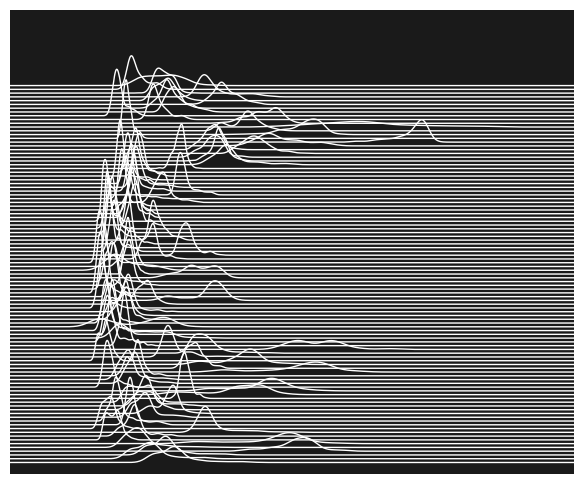

In [ ]:
#If you want something like this, look up joy plots!

In [ ]:
canvas = FigureCanvas(fig)
viewer.window.add_dock_widget(canvas, name="Matplotlib Plot")

#### Dock / Define again widget if necessary

In [ ]:
my_widget7 = highlight()
viewer.window.add_dock_widget(my_widget7)

#### How to add image to Viewer

In [ ]:
viewer.add_image(image) 

<Image layer 'first_image' at 0x325000a40>

#### Test Cellpose

In [ ]:
from cellpose import models, io
import numpy as np

# Initialize Cellpose model (use CPU to avoid GPU issues)
model = models.Cellpose(gpu=False)

# Run Cellpose model on the image
masks, flows, styles, diams = model.eval(first_image, diameter=None, channels=[0, 0])

print("Cellpose processing completed.")

#### Template Widget

In [ ]:
'''
@magicgui(
    threshold={"widget_type": "FloatSlider", "max": 1}, auto_call=True
)
def threshold_magic_widget(
    img_layer: "napari.layers.Image", threshold: "float"
) -> "napari.types.LabelsData":
    return img_as_float(img_layer.data) > threshold

# Create the viewer and add an image
viewer = napari.view_image(data.camera())
# Add widget to viewer
viewer.window.add_dock_widget(threshold_magic_widget)
'''